This is our first and oldest attempt at an Ageing model. It is not directly used in the final report.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
rng = np.random.default_rng(7)

In [10]:
# Initialise parameters:
num_of_agents = 100 # number of agents
Timesteps = 100 # timesteps (1 = no steps taken) in years
R = 0.2 # confidence bound

min_age = 16
max_age = 81
op_drift = 0.01

youth_min_op = 0
youth_max_op = 0.4
youth_op_mu = 0.2
youth_op_std = 0.05

In [4]:
opinions = np.random.rand(num_of_agents) # init all agents to [0,1]

# Ages are distributed according to a skewed normal distribution
a=16; b=80; std = 15; mu = 40
rv = sc.stats.truncnorm((a-mu)/std, (b-mu)/std, loc=mu, scale=std)
ages = np.floor(rv.rvs(size=num_of_agents))

In [5]:
def get_A(opinions,R):
    '''
    A function to return the average opinion within R of each opinion in a vector of opinions
    '''
    
    num_of_agents = len(opinions)

    # Create a square matrix consisting of the opinions vector repeated num_of_agents times
    opinions_repeated = np.array([opinions]*len(opinions))
    # Create matrix of boolean values indicating which opinions are within R of each opinion
    mask = abs(opinions_repeated - opinions_repeated.T) < R
    
    # Initialise averages matrix
    A = np.zeros(num_of_agents)

    # Loop over agents
    for i in range(num_of_agents):
        # Get average of opinions within R of opinion
        A[i] = np.mean(opinions[mask[i,:]])
        # print(A[i])
    
    return(A)

In [8]:
# Initialising matrix of opinions over time
opinions_over_time = np.zeros((Timesteps, num_of_agents))
opinions_over_time[0,:] = opinions

# Initialising matrix of ages over time
ages_over_time = np.zeros((Timesteps,num_of_agents))
ages_over_time[0,:] = ages

for t in range(Timesteps-1):
    # Basic opinion update (minimum necesssary to keep opinions within a range)
    opinions_over_time[t+1,:] = np.minimum(get_A(opinions_over_time[t,:], R) + op_drift, 1.0)
    
    # Update ages
    ages_over_time[t+1,:] = ages_over_time[t,:] + 1

    # Find who dies at next step
    deaths = ages_over_time[t+1,:] > max_age
    num_deaths = sum(deaths)

    # Replace the people who die with young people
    ages_over_time[t+1, deaths] = min_age

    # Initialise new people with normally-distributed opinions within some range
    rv = sc.stats.truncnorm((youth_min_op-youth_op_mu)/youth_op_std, 
                        (youth_max_op-youth_op_mu)/youth_op_std, loc=youth_op_mu, scale=youth_op_std)
    opinions_over_time[t+1,:][deaths] = rv.rvs(size=num_deaths)
    
# print(opinions_over_time)
# print(ages_over_time)

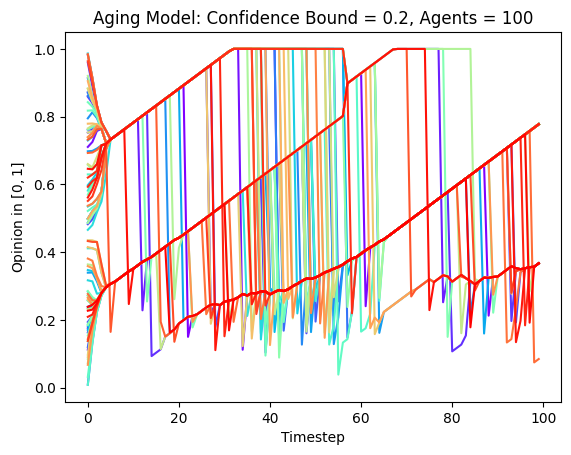

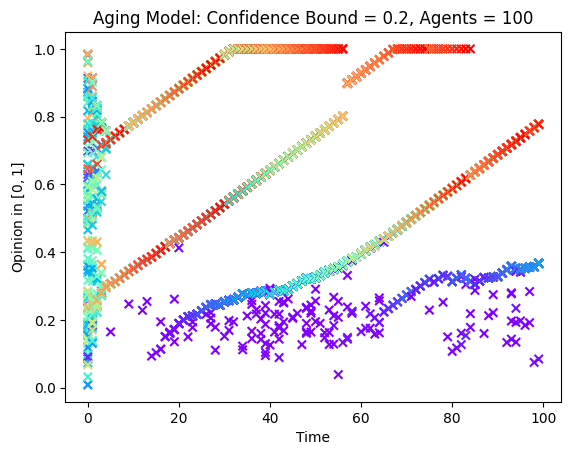

In [9]:
#plotting
colours = plt.cm.rainbow(np.linspace(0,1,num_of_agents))

for i in range(num_of_agents):
    plt.plot(opinions_over_time[:,i],color=colours[i])
plt.title(f'Aging Model: Confidence Bound = {R}, Agents = {num_of_agents}')
plt.xlabel('Timestep')
plt.ylabel('Opinion in $[0,1]$')
plt.show()

#plotting

colours = plt.cm.rainbow(np.linspace(0,1,round(max_age-min_age+1)))
plt.scatter(np.array([range(Timesteps)]*num_of_agents).T, opinions_over_time, c=ages_over_time, cmap='rainbow', marker='x')
plt.title(f'Aging Model: Confidence Bound = {R}, Agents = {num_of_agents}')
plt.xlabel('Time')
plt.ylabel('Opinion in $[0,1]$')
plt.show()